# 1) Using CNN on input:  Rpeak -19 / +20  ticks  (QRS only, both channels)

In [1]:
import os, sys
sys.path.append("./module")
import cnn_ecg as cnn_v1

##### Load up Dataset #1 (Classification) and Dataset #2 (Evaluation)  and create beat segments using inputs

In [2]:
# Set the length of the beat segment -> 40 ticks, appr. 1 QRS-interval
preX = 19
postX = 20
# Load DS1 - train and DS2 - eval datasets
ds1_all, ds1_ann, ds1_seg, ds1_lab = cnn_v1.create_DS("1",preX,postX)
ds2_all, ds2_ann, ds2_seg, ds2_lab = cnn_v1.create_DS("2",preX,postX)


##### Examples of beats obtained from MIT-BIH dataset

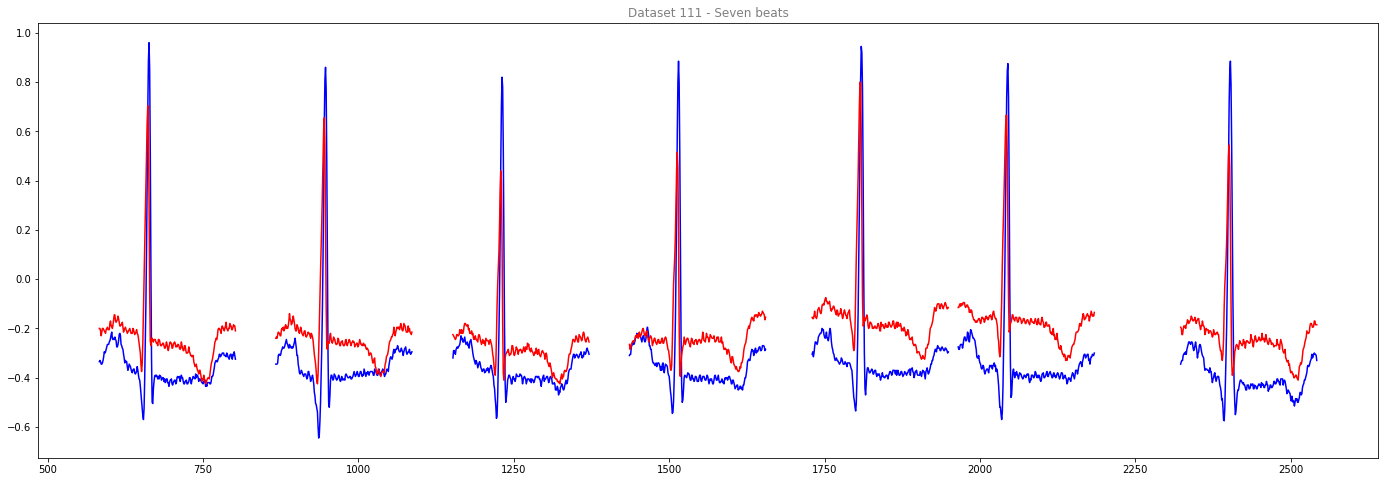

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

preX = 79;
postX = 140;
begNList = [];
endNList = [];
mixNList = [];
sliceNList = [];
    
for index, row in ds2_ann["100"].iterrows():
    Nbegin = row['sample'] - preX;
    Nend = row['sample'] + postX;
    begNList.append(Nbegin);
    endNList.append(Nend);

mixNList = tuple(zip(begNList,endNList)) 
#mixNList[-1]
        
plt.figure(figsize=(24,8))

for x in range(0,7):
    dfseg1 = ds2_all["100"][(ds2_all["100"]['sample'] >= mixNList[x][0]) & (ds2_all["100"]['sample'] <= mixNList[x][1])]
    plt.title('Dataset 111 - Seven beats', color="grey")
    plt.plot(dfseg1['MLII'], color="blue")
    plt.plot(dfseg1['V5'], color="red")

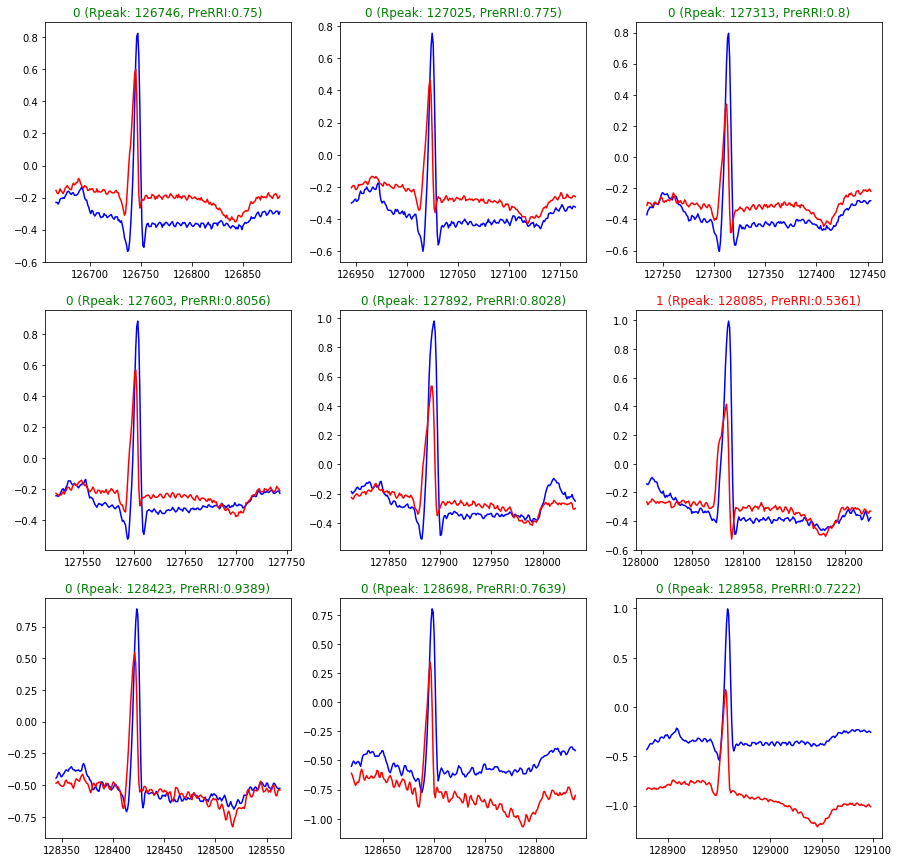

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (15,15))

i = 434 # 20 115        
y = -1
for x in range(0,9):
    if x % 3 == 0:
        y=y+1
    dfseg1 = ds2_all["100"][(ds2_all["100"]['sample'] >= mixNList[x+i][0]) & (ds2_all["100"]['sample'] <= mixNList[x+i][1])]
    
    if str(ds2_ann["100"]['Type'][x+i+1]) != '0':
        axes[y, x % 3].set_title('my title', color="red")
    else:
        axes[y, x % 3].set_title('my title', color="green")
  
    axes[y, x % 3].plot(dfseg1['MLII'], color="blue")
    axes[y, x % 3].plot(dfseg1['V5'], color="red")
    axes[y, x % 3].set_title(str(ds2_ann["100"]['Type'][x+i+1]) + ' (Rpeak: ' + str(ds2_ann["100"]['sample'][x+i+1])  + ', PreRRI:' + str(float("{0:.4f}".format(ds2_ann["100"]['RRI'][x+i+1]))) +  ')' )


##### Create the training and evaluation data and labels

In [3]:
import numpy as np

# Prepare the input vectors as numpy arrays
train_data = ds1_seg
train_labels = np.asarray(ds1_lab, dtype=np.int32)
eval_data = ds2_seg
eval_labels = np.array(ds2_lab, dtype=np.int32)

# The total counts for all classes:
# Beat types:
# 0 - Normal beat  (N)
# 1 - Premature ventricular contraction (V)
# 2 - Atrial premature beat (SVEB)
# 3 - Fusion of ventricular and normal beat (F)
# 4 - Unclassifiable beat (Q)
print(np.unique(train_labels, return_counts=True))
print(np.unique(eval_labels, return_counts=True))



(array([0, 1, 4], dtype=int32), array([1858,    3,    2]))
(array([0, 1, 2], dtype=int32), array([2236,   33,    1]))


##### Graph on convolutional network model

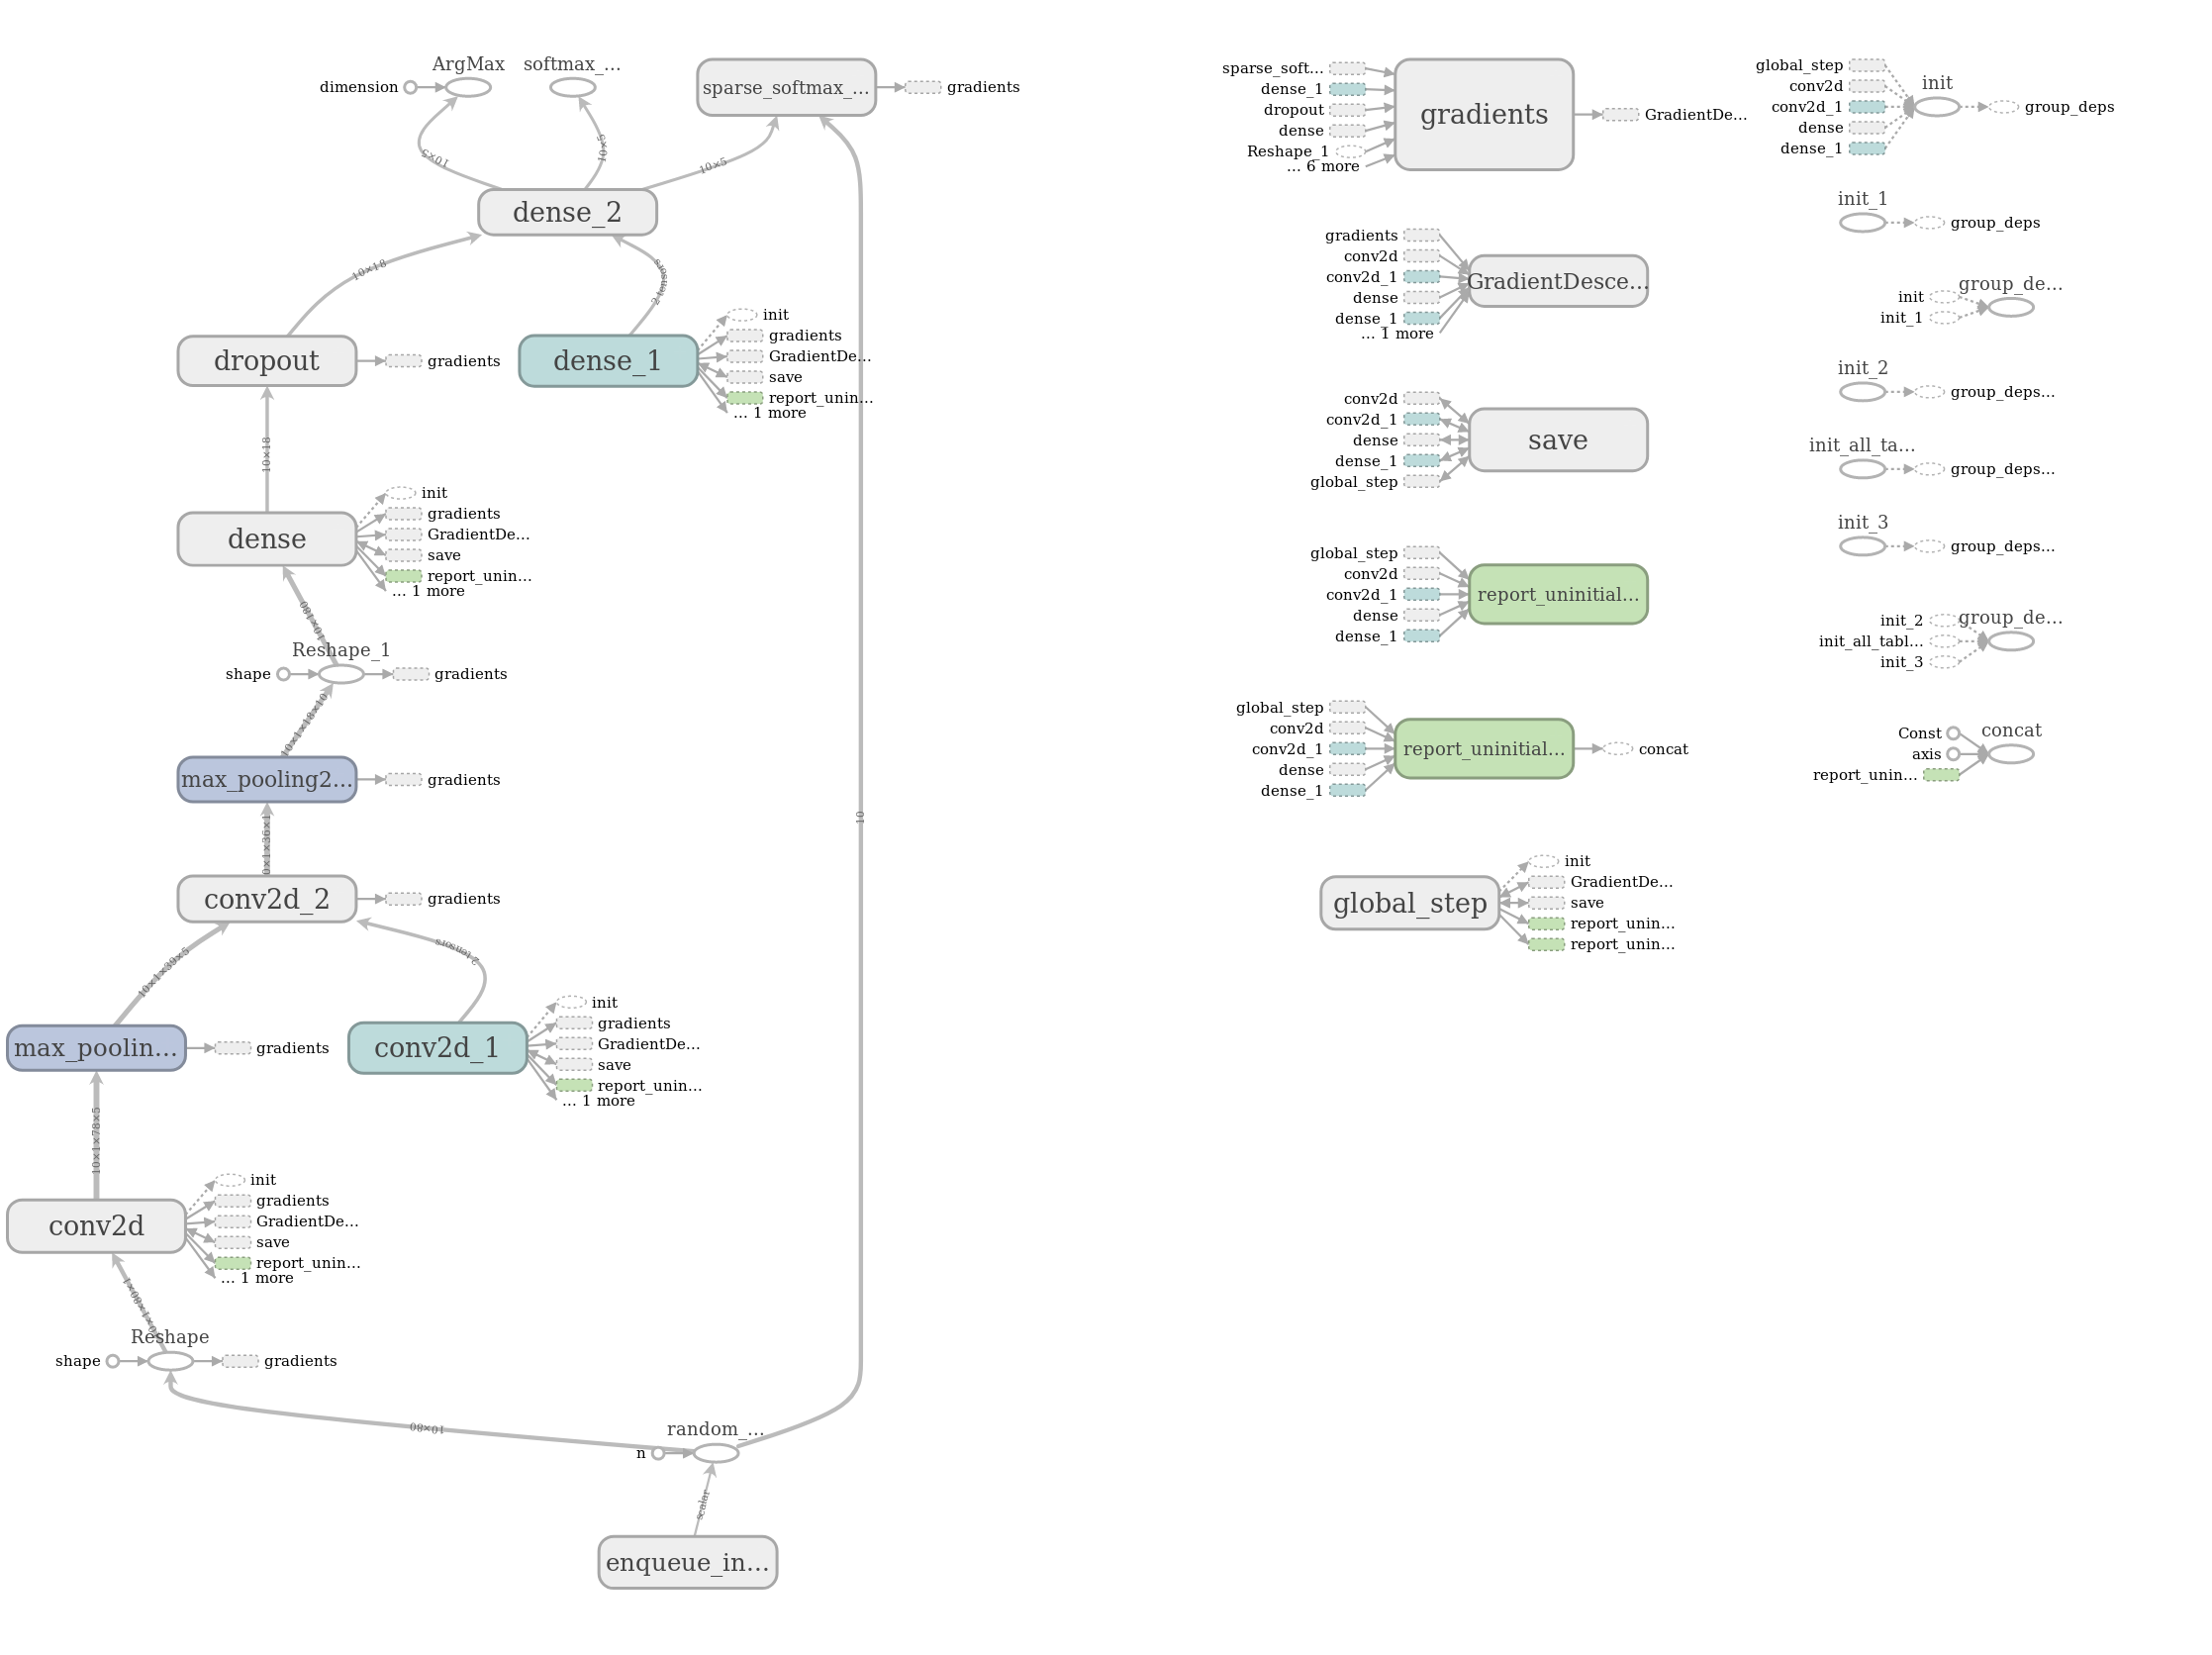

In [35]:
from IPython.display import Image
Image("img/cnn_v1.png")

##### Set up classifier and run the training of the network

In [6]:
import tensorflow as tf

ecg_classifier = tf.estimator.Estimator(model_fn=cnn_v1.cnn_model_fn, model_dir="/tmp/ecg_convnet_model")
    
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
    
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=10,
    num_epochs=None,
    shuffle=True)
ecg_classifier.train(
    input_fn=train_input_fn,
    steps=2000,
    hooks=[logging_hook])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/ecg_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbbb421d208>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/ecg_convnet_model/model.ckpt-24000
INFO:tensorflow:Saving checkpoints for 24001 into /tmp/ecg_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.9400646  0.00661368 0.00107334 0.00041654 0.05183177]
 [0.99439925 0.00452002 0.0005006  0.00013173 0.00044831]
 [0.99746346 0.00075344 0.00090061 0.00008214 0.00080036

INFO:tensorflow:probabilities = [[0.99997497 0.00001109 0.00001101 0.00000008 0.00000285]
 [0.9999043  0.00003605 0.00004683 0.00000053 0.00001226]
 [0.99998057 0.00001354 0.00000309 0.00000009 0.00000274]
 [0.9999434  0.00002064 0.000006   0.00000008 0.00002989]
 [0.99655896 0.00038277 0.00278843 0.00002175 0.0002481 ]
 [0.9969506  0.00216788 0.00038241 0.00010203 0.0003969 ]
 [0.99940133 0.00010684 0.00011565 0.00000121 0.00037494]
 [0.999785   0.00009902 0.00003108 0.00000015 0.00008477]
 [0.9973923  0.00064127 0.00035161 0.00002093 0.00159398]
 [0.9999745  0.00000891 0.00000146 0.00000002 0.00001519]] (0.084 sec)
INFO:tensorflow:global_step/sec: 609.257
INFO:tensorflow:probabilities = [[0.9999727  0.00001701 0.0000049  0.00000002 0.00000532]
 [0.99975866 0.00012072 0.0000525  0.00000556 0.00006241]
 [0.99792165 0.00052567 0.00144954 0.00001407 0.00008912]
 [0.999171   0.00050585 0.00004859 0.00000203 0.00027251]
 [0.9997826  0.00003293 0.00011712 0.00000011 0.00006722]
 [0.9999974 

INFO:tensorflow:global_step/sec: 550.968
INFO:tensorflow:probabilities = [[0.9999995  0.00000019 0.00000008 0.         0.00000008]
 [0.999521   0.00018973 0.00020915 0.00000096 0.00007924]
 [0.9999069  0.00000991 0.0000045  0.00000006 0.0000785 ]
 [0.9998884  0.00001236 0.00005626 0.00000005 0.00004295]
 [0.93449956 0.01068299 0.00779297 0.00873396 0.03829053]
 [0.99998176 0.00000517 0.00000018 0.00000001 0.00001303]
 [0.9999889  0.0000081  0.00000148 0.00000004 0.00000156]
 [0.9998703  0.0000681  0.00003592 0.00000008 0.00002567]
 [0.9999933  0.00000503 0.0000008  0.         0.00000079]
 [0.999925   0.00003532 0.00000812 0.00000157 0.00003006]] (0.091 sec)
INFO:tensorflow:loss = 0.0068669072, step = 25201 (0.182 sec)
INFO:tensorflow:probabilities = [[0.9999248  0.00000855 0.00002462 0.00000003 0.00004191]
 [0.98543024 0.00070124 0.0114691  0.00023317 0.00216631]
 [0.9993612  0.00030604 0.00032493 0.00000092 0.00000688]
 [0.9999851  0.00000405 0.00000018 0.00000001 0.00001062]
 [0.9998

INFO:tensorflow:loss = 0.0015330655, step = 25801 (0.191 sec)
INFO:tensorflow:probabilities = [[0.99998283 0.00000638 0.00000695 0.0000001  0.0000038 ]
 [0.99996376 0.000004   0.00000261 0.00000001 0.00002954]
 [0.9976209  0.00171931 0.00020251 0.00008109 0.0003761 ]
 [0.997053   0.00081755 0.00033209 0.00001872 0.00177857]
 [0.9999442  0.00001    0.00000726 0.00000027 0.00003831]
 [0.99884987 0.00041623 0.00072175 0.00000173 0.00001045]
 [0.99994755 0.00003475 0.00001328 0.00000002 0.00000437]
 [0.9714167  0.01330099 0.00146329 0.00360822 0.01021086]
 [0.9999707  0.0000087  0.00000042 0.00000002 0.00002025]
 [0.9999912  0.00000701 0.00000088 0.         0.00000097]] (0.108 sec)
INFO:tensorflow:global_step/sec: 486.578
INFO:tensorflow:probabilities = [[0.9999949  0.00000208 0.00000292 0.         0.00000026]
 [0.99999356 0.00000226 0.00000398 0.         0.0000003 ]
 [0.99974996 0.00013391 0.00006634 0.00000025 0.00004941]
 [0.9995832  0.00004361 0.00036582 0.00000033 0.00000698]
 [0.9988

##### Run evaluation of the model

In [9]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=30,
    shuffle=False)
eval_results = ecg_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)
 

INFO:tensorflow:Starting evaluation at 2018-04-06-16:42:50
INFO:tensorflow:Restoring parameters from /tmp/ecg_convnet_model/model.ckpt-24000
INFO:tensorflow:Finished evaluation at 2018-04-06-16:42:51
INFO:tensorflow:Saving dict for global step 24000: accuracy = 0.98546255, global_step = 24000, loss = 0.112461545
{'accuracy': 0.98546255, 'loss': 0.112461545, 'global_step': 24000}


##### Create the beat segments - first with (-19 <-R_peak -> +20) interval